In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import joblib
from joblib import load
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.ensemble import RandomForestRegressor

from itertools import product


from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold, RandomizedSearchCV
import multiprocessing

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score,roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

import pickle  # Para cargar el modelo guardado

### (PARENTESIS)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


## 1. Carga de datos

In [3]:

data = pd.read_csv('df_con_grid.csv')


### Crear variables

In [4]:

# Definir la normalización de las variables


#Consideramos que el riesgo aumenta conforme la temperatura se aleja de un valor seguro, 
# por ejemplo, 30°C. A partir de los 40°C ya el riesgo se vuelve muy alto.
def Temperatura_normalizada(temperature):
    return max(0, min(1, (temperature - 30) / (40 - 30)))

#El riesgo de incendio crece cuando la humedad es muy baja. 
# Consideramos que la humedad es más peligrosa por debajo de un 30%.
def Humedad_normalizada(humidity):
    return max(0, min(1, (30 - humidity) / 30))

#La velocidad del viento también tiene un impacto importante. 
# Por ejemplo, un viento superior a 30 km/h puede hacer que un incendio se propague rápidamente.
def Viento_normalizado(wind_speed):
    return max(0, min(1, (wind_speed - 30) / (60 - 30)))

# Crear la nueva variable 'fire_risk_index' con la fórmula ponderada segun la importancia relativa que he considerado 
# donde he dado menos importancia al la velocidad del viendo que las otras dos variables T y H
def calculate_fire_risk(row):
    Temperature = Temperatura_normalizada(row['Temperature (C)']) 
    Humedad = Humedad_normalizada(row['Humidity (%)']) 
    Viento = Viento_normalizado(row['V_VIENTO']) 
    
    # Índice ponderado 30/30/30
    fire_risk_index = 0.4 * Temperature + 0.4 * Humedad + 0.2 * Viento
    
    return fire_risk_index

# Crear la nueva columna en el DataFrame
data['fire_risk_index'] = data.apply(calculate_fire_risk, axis=1)

# Guardar el DataFrame actualizado en un nuevo archivo CSV
output_file = 'df_con_grid_fire.csv'  #
data.to_csv(output_file, index=False)

print(f"Índice de riesgo de incendio calculado y guardado en '{output_file}'")


Índice de riesgo de incendio calculado y guardado en 'df_con_grid_fire.csv'


In [5]:
# Feature 1: 
data['difficulty_viento_humedad'] = data['DifficultyIndex'] * (data['V_VIENTO'] + data['Humidity (%)'])

# Feature 2:
data['fire_risk_fuel'] = data['fire_risk_index'] * (data['FuelLoadIndex'] / 100)

# Feature 3: 
data['fire_risk_landcover'] = data['fire_risk_index'] * data['LandCover']


output_file = 'df_con_grid_fire.csv'  #
data.to_csv(output_file, index=False)

print(f"Índice de riesgo de incendio calculado y guardado en '{output_file}'")

Índice de riesgo de incendio calculado y guardado en 'df_con_grid_fire.csv'


Creo a continuacion las variables de tipo clase para predecir si hay que madar o no aviones, buldozzer o helicopteros

In [6]:

data = pd.read_csv('df_con_grid_fire.csv')

In [7]:


def AvionAnfibio(range_str):
    if range_str == 0:
        return 0
    
    else:
        return 1


data['AVIANFNUM_CLASS'] = data['AVIANFNUM'].apply(AvionAnfibio)

## 2. Filtrar datos

Se eliminan los datos que no pertenecen a la comunidad valenciana y que son dependientes de de la longuitud y la latitud.
Alguno de los datos que quedan pueden ser de otra comunidad dado que limitamos en cuadrado y la comunidad valenciana no es un rectangulo si no que tiene entradas y salidad del terreno

In [11]:
data = data.replace({',': ''}, regex=True)



Datos originales: (10526, 168)
Datos filtrados: (10526, 168)


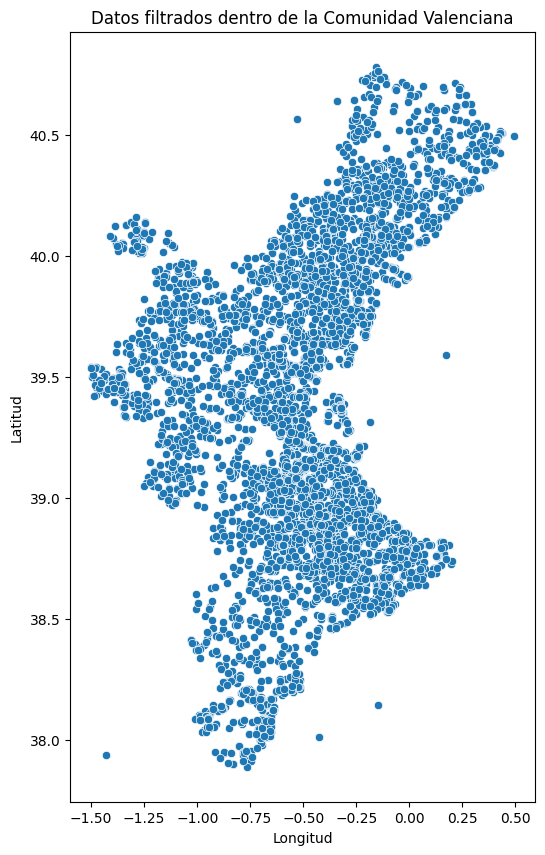

In [12]:
# Se incluyen unicamente los datos que estan dentro de las coordenadas correctas de la comunidad valenciana
data_filtrado = data[
    (data['Latitude'] <= 42) & (data['Latitude'] >= 36) &  # Latitude
    
    (data['Longitude'] <= 0.6) & (data['Longitude'] >= -1.7)  # Longitude
]

print(f"Datos originales: {data.shape}")
print(f"Datos filtrados: {data_filtrado.shape}")

# Gráfico
plt.figure(figsize=(6,10))
sns.scatterplot(data=data_filtrado, x='Longitude', y='Latitude')
plt.title("Datos filtrados dentro de la Comunidad Valenciana")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


# AVIÓN ANFIBIO DESCARGA

## 3. Análisis exploratorio

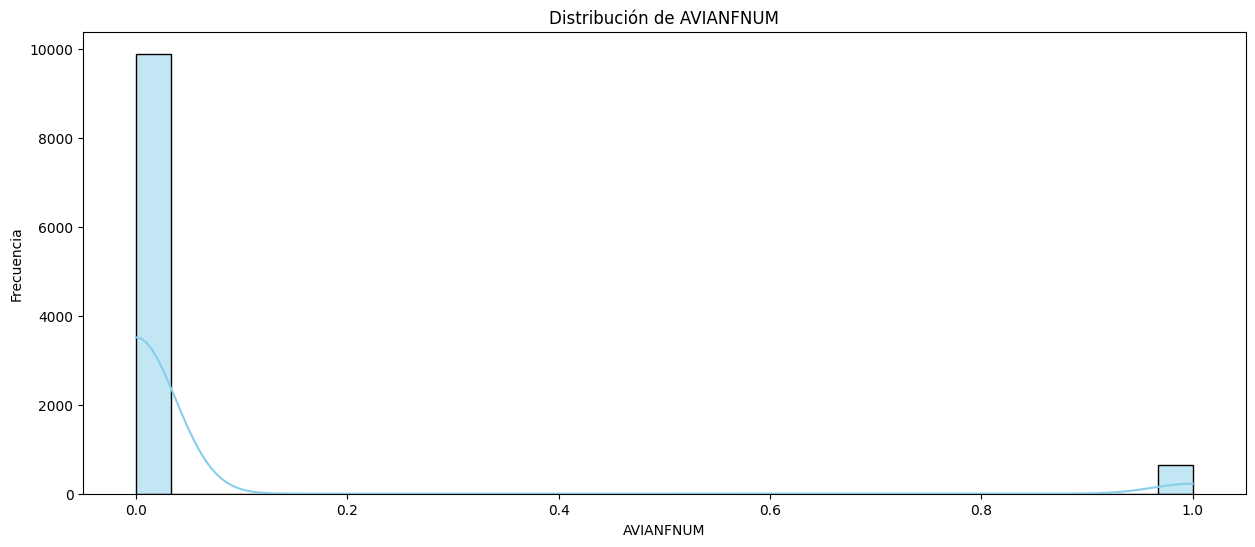

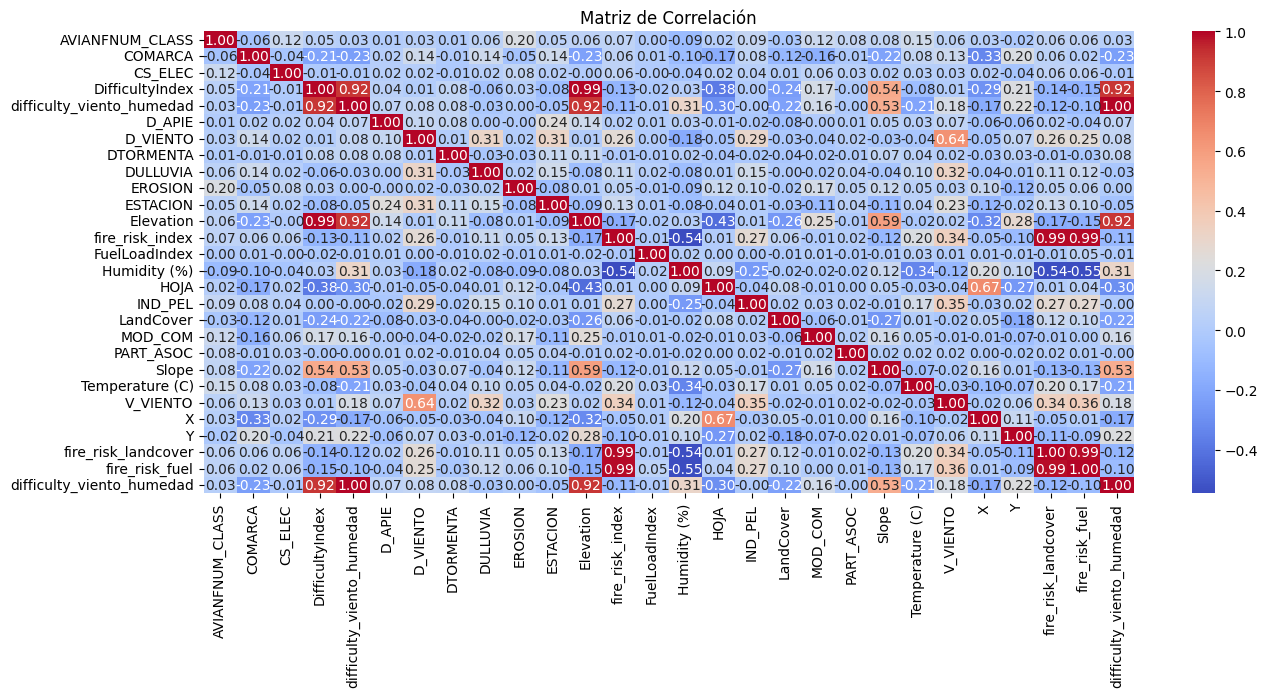

In [14]:
var = data_filtrado[['AVIANFNUM_CLASS','COMARCA','CS_ELEC','DifficultyIndex','difficulty_viento_humedad','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]

plt.figure(figsize=(15, 6))
sns.histplot(data_filtrado, x='AVIANFNUM_CLASS', kde=True ,bins=30, color='skyblue')

plt.title('Distribución de AVIANFNUM')
plt.xlabel('AVIANFNUM')
plt.ylabel('Frecuencia')
plt.show()



# Correlación entre variables numéricas y AVIANFNUM
plt.figure(figsize=(15, 6))
correlation_matrix = var.corr(method= 'spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


Elimino Elevación de la primeras variables a estudiar, porque tiene mucha relacion con el `DifficultyIndex` ya que este se calcula con la ``elevacion``,``LandCoverIndex`` y el ``Slope``.

Tambien quito ``D_Viento`` porque esta relacionado con el de ``V_Viento``

Con las coordenadas también puedo quitar `'COM_CODICV'`

In [16]:

X = data_filtrado[['COMARCA','CS_ELEC','DifficultyIndex','difficulty_viento_humedad','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = data_filtrado[ 'AVIANFNUM_CLASS']

In [17]:
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

Miro la importancia y entonces quito los ultimos que considera que tiene menos importancia para el modelo. Aunque vamos a hacer un Random forest y esto no afecta tanto como en uno lineal, quiro reducir la el tiempo de computo

In [18]:
importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print(importance_df)




                      Feature  Importance
20            Temperature (C)    0.090064
13               Humidity (%)    0.068144
19                      Slope    0.061160
26  difficulty_viento_humedad    0.058096
3   difficulty_viento_humedad    0.057500
23                          Y    0.055467
22                          X    0.053672
8                     EROSION    0.052042
2             DifficultyIndex    0.051260
7                    DULLUVIA    0.045475
10                  Elevation    0.043423
5                    D_VIENTO    0.039742
21                   V_VIENTO    0.039339
17                    MOD_COM    0.039323
0                     COMARCA    0.035768
9                    ESTACION    0.023966
24        fire_risk_landcover    0.022722
11            fire_risk_index    0.022370
15                    IND_PEL    0.021069
4                      D_APIE    0.020962
25             fire_risk_fuel    0.020787
12              FuelLoadIndex    0.020592
16                  LandCover    0

## 4.Modelos Clasificacion: AVIÓN ANFIBIO DESCARGA

Primero tenemos que saber si necesitamos `1` o no `0` aviones ANFIBIOS DE DESCARGA. He quitado algunas de las variables para que nos quite tiempo de procesado ya que al importancia  que le da es muy baja, y además por ejemplo `Hoja`hemos visto arriba que estaba correlacionada

In [ ]:
#Nuevo modelo

X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','D_VIENTO','DULLUVIA',
             'EROSION','ESTACION','FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel']] 
y = data_filtrado[ 'AVIANFDES_CLASS']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X = data_filtrado[['DifficultyIndex','difficulty_viento_humedad','D_APIE','D_VIENTO','DULLUVIA',
             'EROSION','ESTACION','fire_risk_index','fire_risk_landcover','FuelLoadIndex','Humidity (%)','LandCover',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y']] 
y = data_filtrado[ 'AVIANFDES_CLASS']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Comprobar si el modelo es balanceado o no

In [1132]:
data_filtrado['AVIANFDES_CLASS'].value_counts().unique

<bound method Series.unique of AVIANFDES_CLASS
0    9923
1     603
Name: count, dtype: int64>

Random Forest - AUC: 0.7648, Accuracy: 0.9421
XGBoost - AUC: 0.7600, Accuracy: 0.9405
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 421, number of negative: 6947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2438
[LightGBM] [Info] Number of data points in the train set: 7368, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057139 -> initscore=-2.803432
[LightGBM] [Info] Start training from score -2.803432


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:25:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LightGBM - AUC: 0.7711, Accuracy: 0.9427
CatBoost - AUC: 0.7888, Accuracy: 0.9421


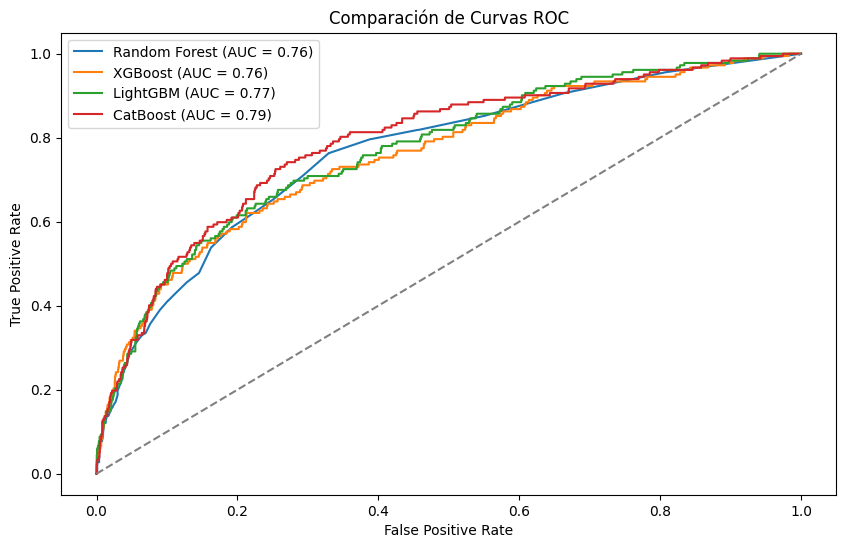

In [20]:



models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Entrenamiento y evaluación
results = {}
for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluación
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {"AUC": auc, "Accuracy": accuracy}
    
    # Imprimir métricas
    print(f"{name} - AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")

# Comparar las curvas ROC
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['AUC']:.2f})")

# Línea base
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de Curvas ROC')
plt.legend()
plt.show()



### 4.1. Random forest Classifier 

In [21]:
forest = RandomForestClassifier (random_state=42, class_weight='balanced')

In [22]:
forest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [23]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.9414
Precisión sobre datos de train: 0.9996


In [24]:
predicciones = forest.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2968    8]
 [ 177    5]]

El accuracy de test es: 94.1418619379354 %
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2976
           1       0.38      0.03      0.05       182

    accuracy                           0.94      3158
   macro avg       0.66      0.51      0.51      3158
weighted avg       0.91      0.94      0.92      3158



In [1199]:
param_range = [30,40,50,60,90,100,130,150,200,300,500]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [1200]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 30 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 40 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 50 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 60 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 90 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 100 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 130 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 150 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 200 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())
print ('n_estimators 500 en test:',test_score[10].mean(),'en train:',train_score[10].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 30 en test: 0.9415036463673117 en train: 0.9969462482943653
n_estimators 40 en test: 0.9421823487634959 en train: 0.9978623651717522
n_estimators 50 en test: 0.9421824408783707 en train: 0.9983713285861932
n_estimators 60 en test: 0.9420467556680585 en train: 0.9985070253010997
n_estimators 90 en test: 0.9421826251081198 en train: 0.9990498985037615
n_estimators 100 en test: 0.9421825329932452 en train: 0.999015977203136
n_estimators 130 en test: 0.9420469398978077 en train: 0.9991177698860243
n_estimators 150 en test: 0.9423183103184319 en train: 0.999151696942852
n_estimators 200 en test: 0.9424541797584931 en train: 0.999151696942852
n_estimators 300 en test: 0.9419112546874956 en train: 0.9990838428291966
n_estimators 500 en test: 0.9420469398978077 en train: 0.9990838428291966


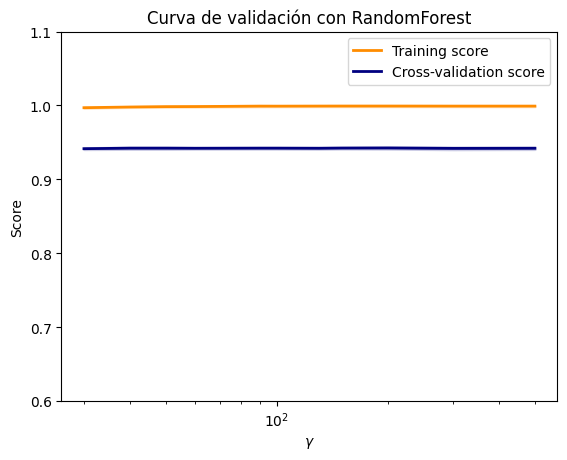

In [1201]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

plt.title("Curva de validación con RandomForest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.6, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [25]:
# Arboles
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 50)]

# Características de los arboles en número
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,  'sqrt', 'log2']
max_features.append('auto')

# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 8, 10]

# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2 ,3, 4, 5]

# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 90)]
max_leaf_nodes.append(None)


param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}


In [26]:
forest_random = RandomizedSearchCV(estimator = forest, 
                                   param_distributions = param_grid, 
                                   n_iter = 30, 
                                   cv = 5, 
                                   scoring='roc_auc',
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = 1)


In [27]:
forest_random.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=30, n_jobs=1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         'sqrt', 'log2',
                                                         'auto'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 5, 8, 10],
                                        'n_estimators': [50, 55, 60, 65, 70, 75,
                                                         80, 85, 90, 95, 101,
                                                         106, 111, 116, 121,
                                                         126, 131, 136, 141,
                                                         146, 152, 157, 162,
                                                         167, 172, 177, 182,
                                                         187, 192, 197, ...]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [32]:
best_forest = forest_random.best_estimator_

<BarContainer object of 18 artists>

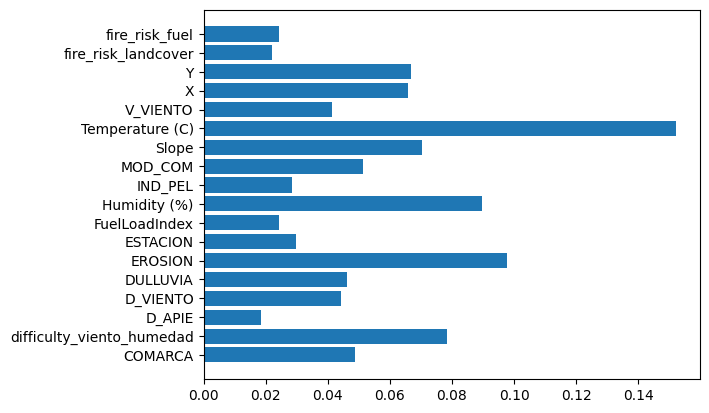

In [33]:
plt.barh(X.columns, best_forest.feature_importances_)

In [34]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=90, max_features=3,
                       min_samples_leaf=4, n_estimators=238, random_state=42)

In [35]:
print('BALANCED_ BEST_PARAMS_')

print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

BALANCED_ BEST_PARAMS_
Precisión sobre datos de pruebas: 0.9392
Precisión sobre datos de train: 0.9963


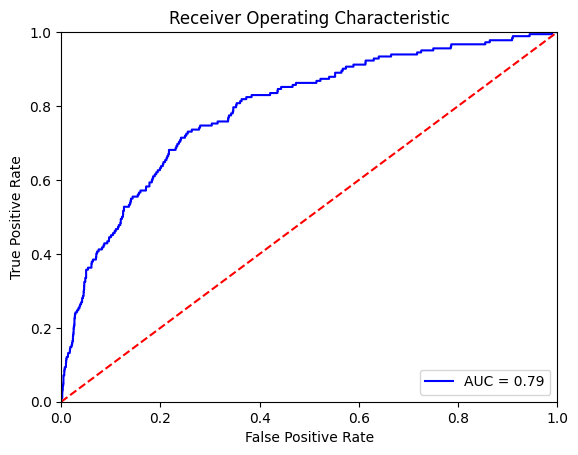

In [37]:
probs = best_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
predicciones = best_forest.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2945   31]
 [ 161   21]]

El accuracy de test es: 93.92020265991134 %
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2976
           1       0.40      0.12      0.18       182

    accuracy                           0.94      3158
   macro avg       0.68      0.55      0.57      3158
weighted avg       0.92      0.94      0.92      3158



In [39]:
#Rango umbrales en pasos pequeños
thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

# Metricas por umbral
for threshold in thresholds:
    y_pred_adjusted = (preds >= threshold).astype(int)  # Aplicar el umbral
    precisions.append(precision_score(y_test, y_pred_adjusted))
    recalls.append(recall_score(y_test, y_pred_adjusted))
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# resultados
for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}, F1-score: {f1_scores[i]:.4f}")


Umbral: 0.1, Precision: 0.1128, Recall: 0.8297, F1-score: 0.1986
Umbral: 0.2, Precision: 0.1810, Recall: 0.5659, F1-score: 0.2743
Umbral: 0.3, Precision: 0.2583, Recall: 0.3846, F1-score: 0.3091
Umbral: 0.4, Precision: 0.3305, Recall: 0.2143, F1-score: 0.2600
Umbral: 0.5, Precision: 0.4038, Recall: 0.1154, F1-score: 0.1795
Umbral: 0.6, Precision: 0.4583, Recall: 0.0604, F1-score: 0.1068
Umbral: 0.7, Precision: 0.3333, Recall: 0.0110, F1-score: 0.0213
Umbral: 0.8, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Umbral: 0.9, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


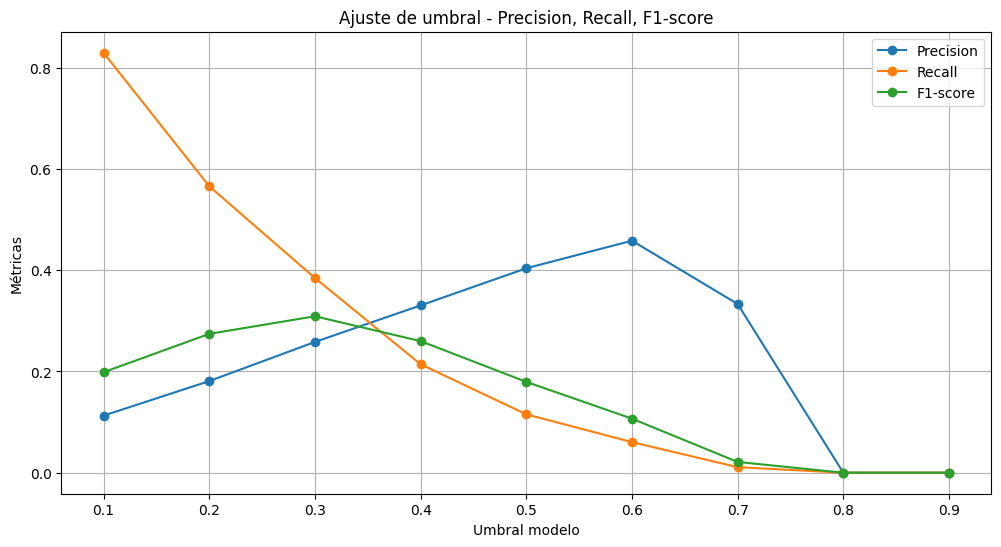

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.xlabel('Umbral modelo')
plt.ylabel('Métricas')
plt.title('Ajuste de umbral - Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
# Coste de un falso positivo (enviar un avión innecesariamente)
cost_fp = 4208.61*2  # Coste de enviar un avión segun los datos que tenemos en la introducción de coste hora.
# pongo un *2 porque en la comunidad valenciana tienen 2 y suponemos que mandamos todas las unidades

# Estimación del coste de un falso negativo (no enviar un avión cuando es necesario)
cost_fn = (6343*0.07) # Un valor extraido de las hectarias mediana (medias muy altas) quemadas en los datos obtenidos 
#y el coste medio de perdida medio ambiental segúnhttps://evenor-tech.com/el-coste-economico-de-los-incendios-forestales/

thresholds = np.arange(0.1, 1.0, 0.1)
total_costs = []

for threshold in thresholds:
    # Aplicar el umbral para hacer las predicciones ajustadas
    y_pred_adjusted = (preds >= threshold).astype(int)
    
    # Calculoo FP y FN
    false_positive = ((y_pred_adjusted == 1) & (y_test == 0)).sum()
    false_negative = ((y_pred_adjusted == 0) & (y_test == 1)).sum()

    # Coste total
    total_cost = (false_positive * cost_fp) + (false_negative * cost_fn)
    total_costs.append(total_cost)


for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Coste total: {total_costs[i]:.2f} €")


Umbral: 0.1, Coste total: 10013421.67 €
Umbral: 0.2, Coste total: 3957501.31 €
Umbral: 0.3, Coste total: 1741590.34 €
Umbral: 0.4, Coste total: 728453.81 €
Umbral: 0.5, Coste total: 332419.43 €
Umbral: 0.6, Coste total: 185349.57 €
Umbral: 0.7, Coste total: 113590.68 €
Umbral: 0.8, Coste total: 80809.82 €
Umbral: 0.9, Coste total: 80809.82 €


Teniendo en cuenta las catastofre natura en la comunidad Valencia en la actualidad (Dana, 2024), se decide tener un sesgo hacia la preservación de la naturaleza frente al coste económico que puede suponer un falso positivo, ya que la situación socal puede ser determinante en costes posteriores (costes socio-economicos-politicos)

Por eso se decide un `Umbral de 0,38` Para mejorar el Recall de los positivos `1`

In [ ]:
# Ajuste umbral
threshold = 0.2
y_pred_adjusted = (preds  >= threshold).astype(int)

In [48]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )


print(confusion_matrix(y_test, y_pred_adjusted))

print(f"El accuracy de test es: {100 * accuracy} %")

print(classification_report(y_test, y_pred_adjusted))



[[2510  466]
 [  79  103]]
El accuracy de test es: 93.92020265991134 %
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2976
           1       0.18      0.57      0.27       182

    accuracy                           0.83      3158
   macro avg       0.58      0.70      0.59      3158
weighted avg       0.92      0.83      0.87      3158



In [1239]:
filename = '../Modelos/Aviones_descarga/best_forest_anfibio.pkl'

In [1241]:
model_and_threshold = {
    'model': best_forest,
    'threshold': threshold}

    
joblib.dump(model_and_threshold, filename)

['../Modelos/Aviones_descarga/best_forest_anfibio.pkl']

### 4.2 Gradient Boosting

In [1246]:

X = data_filtrado[['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = data_filtrado[ 'AVIANFNUM_CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
lgb_clf =lgb.LGBMClassifier(random_state=42, class_weight='balanced')

In [50]:
lgb_clf.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 421, number of negative: 6947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2438
[LightGBM] [Info] Number of data points in the train set: 7368, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [51]:

importance = lgb_clf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print(importance_df)


                      Feature  Importance
12            Temperature (C)         348
1   difficulty_viento_humedad         341
8                Humidity (%)         312
14                          X         276
15                          Y         260
11                      Slope         258
4                    DULLUVIA         167
13                   V_VIENTO         151
3                    D_VIENTO         129
0                     COMARCA         121
10                    MOD_COM         113
6                    ESTACION         101
5                     EROSION          87
17             fire_risk_fuel          79
2                      D_APIE          77
7               FuelLoadIndex          72
16        fire_risk_landcover          57
9                     IND_PEL          51


In [1250]:

X = data_filtrado[['COMARCA','DifficultyIndex','D_APIE','D_VIENTO','DULLUVIA',
             'EROSION','ESTACION','Elevation','FuelLoadIndex','Humidity (%)','IND_PEL','LandCover',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_fuel','difficulty_viento_humedad']]
y = data_filtrado[ 'AVIANFNUM_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Tengo error que no me permite el poder hacer le modelo por lo tanto lo que hago es intentar anular ese error haciendo que los objetos se conviertan en int o float

In [52]:

object_columns = X_train.select_dtypes(include=['object']).columns
print("Columnas con dtype object:", object_columns)

# Convertir a numérico (si los valores son realmente números)
for col in object_columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

print(X_train.dtypes)

Columnas con dtype object: Index([], dtype='object')
COMARCA                        int64
difficulty_viento_humedad    float64
D_APIE                         int64
D_VIENTO                       int64
DULLUVIA                       int64
EROSION                        int64
ESTACION                       int64
FuelLoadIndex                float64
Humidity (%)                 float64
IND_PEL                        int64
MOD_COM                        int64
Slope                        float64
Temperature (C)              float64
V_VIENTO                       int64
X                            float64
Y                            float64
fire_risk_landcover          float64
fire_risk_fuel               float64
dtype: object


In [53]:
X_train['COMARCA'].mean()


2610.910016286645

In [54]:
lgb_clf.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 421, number of negative: 6947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2438
[LightGBM] [Info] Number of data points in the train set: 7368, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [55]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8993
Precisión sobre el juego de train: 0.9658


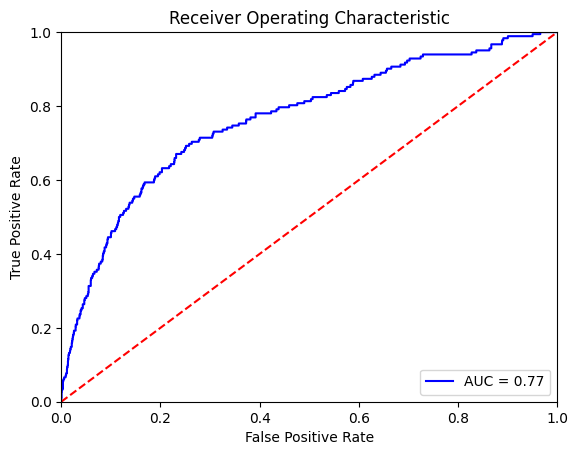

In [57]:
probs = lgb_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
predicciones = lgb_clf.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2776  200]
 [ 118   64]]

El accuracy de test es: 89.93033565547816 %
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2976
           1       0.24      0.35      0.29       182

    accuracy                           0.90      3158
   macro avg       0.60      0.64      0.62      3158
weighted avg       0.92      0.90      0.91      3158



In [1259]:
param_range = [20,60,90,100,150,200,250,300,400,500]
train_score, test_score= validation_curve(
                                lgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 354, number of negative: 5540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2684
[LightGBM] [Info] Number of data points in the train set: 5894, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 354, number of negative: 5540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2684
[LightGBM] [Info] Numb

In [1260]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 10 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 60 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 90 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 100 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 150 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 200 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 250 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 300 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 400 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 500 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 10 en test: 0.8296695563102834 en train : 0.8710301098312195
n_estimators 60 en test: 0.8857210890557395 en train: 0.9470345513169759
n_estimators 90 en test: 0.9041802651250321 en train: 0.9740093072036282
n_estimators 100 en test: 0.9092016311701997 en train: 0.9796756495082908
n_estimators 150 en test: 0.9208747965412707 en train: 0.9948086364909269
n_estimators 200 en test: 0.9273892525891189 en train: 0.9983034859849423
n_estimators 250 en test: 0.9332249141259081 en train: 0.998880286244432
n_estimators 300 en test: 0.9351254282190233 en train: 0.999219585593722
n_estimators 400 en test: 0.9377038156744513 en train: 0.9993892439026707
n_estimators 500 en test: 0.9375681304641393 en train: 0.9993892439026707


In [59]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]

# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)

# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 50)]

# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))

# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]

#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]

# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [100, 106, 112, 118, 124, 130, 136, 142, 148, 155, 161, 167, 173, 179, 185, 191, 197, 204, 210, 216, 222, 228, 234, 240, 246, 253, 259, 265, 271, 277, 283, 289, 295, 302, 308, 314, 320, 326, 332, 338, 344, 351, 357, 363, 369, 375, 381, 387, 393, 400], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [60]:
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, 
                                   param_distributions = param_grid, 
                                   n_iter = 50, 
                                   cv = 5, 
                                   scoring='roc_auc',
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = 1)

In [61]:
light_gbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 5557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 5894, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_iter=50, n_jobs=1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'learning_rate': [0.005, 0.1, 0.2, 0.3,
                                                          0.4, 0.5, 0.6, 0.7,
                                                          0.8, 0.9, 1.0],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_child_samples': [1, 5, 9, 14, 18,
                                                              22, 27, 31, 35,
                                                              40],
                                        'min_split_gain': [0.0...
                                                         246, 253, 259, 265,
                                                         271, 277, ...],
                                        'num_leaves': [30, 40, 50, 60, 70, 80,
                                                       90, 100, 110],
                                        'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0],
                                        'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                       0.5, 0.6, 0.7, 0.8, 0.9,
                                                       1.0],
                                        'subsample_for_bin': [20000, 40000,
                                                              60000, 80000,
                                                              100000, 120000,
                                                              140000, 160000,
                                                              180000, 200000,
                                                              220000, 240000,
                                                              260000, 280000]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [109]:
best_light_gbm = light_gbm_random.best_estimator_

<BarContainer object of 18 artists>

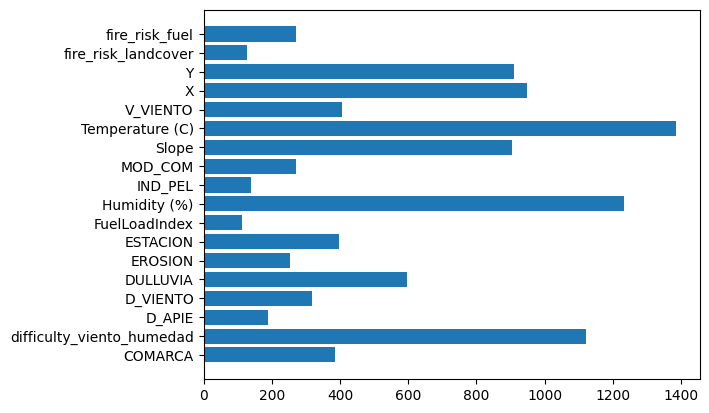

In [110]:
plt.barh(X.columns, best_light_gbm.feature_importances_)

In [111]:
best_light_gbm.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 421, number of negative: 6947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2438
[LightGBM] [Info] Number of data points in the train set: 7368, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(boosting_type='dart', class_weight='balanced', learning_rate=0.2,
               max_depth=50, min_child_samples=22, min_split_gain=0.8,
               n_estimators=295, num_leaves=40, random_state=42, reg_alpha=1.0,
               reg_lambda=0.5)

In [113]:
print('BALANCED_ BEST_PARAMS_')

print("Precisión sobre el juego de test: {:.4f}"
      .format(best_light_gbm.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_light_gbm.score(X_train, y_train)))

BALANCED_ BEST_PARAMS_
Precisión sobre el juego de test: 0.9028
Precisión sobre el juego de train: 0.9703


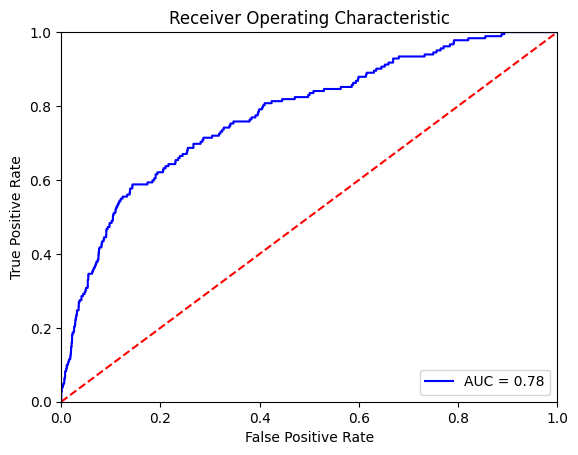

In [115]:
probs = best_light_gbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [117]:
predicciones = best_light_gbm.predict(X = X_test)
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2787  189]
 [ 118   64]]

El accuracy de test es: 90.2786573780874 %
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2976
           1       0.25      0.35      0.29       182

    accuracy                           0.90      3158
   macro avg       0.61      0.64      0.62      3158
weighted avg       0.92      0.90      0.91      3158



In [119]:
#Rango umbrales en pasos pequeños
thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

# Metricas por umbral
for threshold in thresholds:
    y_pred_adjusted = (preds >= threshold).astype(int)  # Aplicar el umbral
    precisions.append(precision_score(y_test, y_pred_adjusted))
    recalls.append(recall_score(y_test, y_pred_adjusted))
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# resultados
for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}, F1-score: {f1_scores[i]:.4f}")


Umbral: 0.1, Precision: 0.1069, Recall: 0.7747, F1-score: 0.1879
Umbral: 0.2, Precision: 0.1502, Recall: 0.6429, F1-score: 0.2435
Umbral: 0.3, Precision: 0.1996, Recall: 0.5769, F1-score: 0.2966
Umbral: 0.4, Precision: 0.2343, Recall: 0.4725, F1-score: 0.3133
Umbral: 0.5, Precision: 0.2530, Recall: 0.3516, F1-score: 0.2943
Umbral: 0.6, Precision: 0.2924, Recall: 0.2747, F1-score: 0.2833
Umbral: 0.7, Precision: 0.3333, Recall: 0.1813, F1-score: 0.2349
Umbral: 0.8, Precision: 0.3462, Recall: 0.0989, F1-score: 0.1538
Umbral: 0.9, Precision: 0.5833, Recall: 0.0385, F1-score: 0.0722


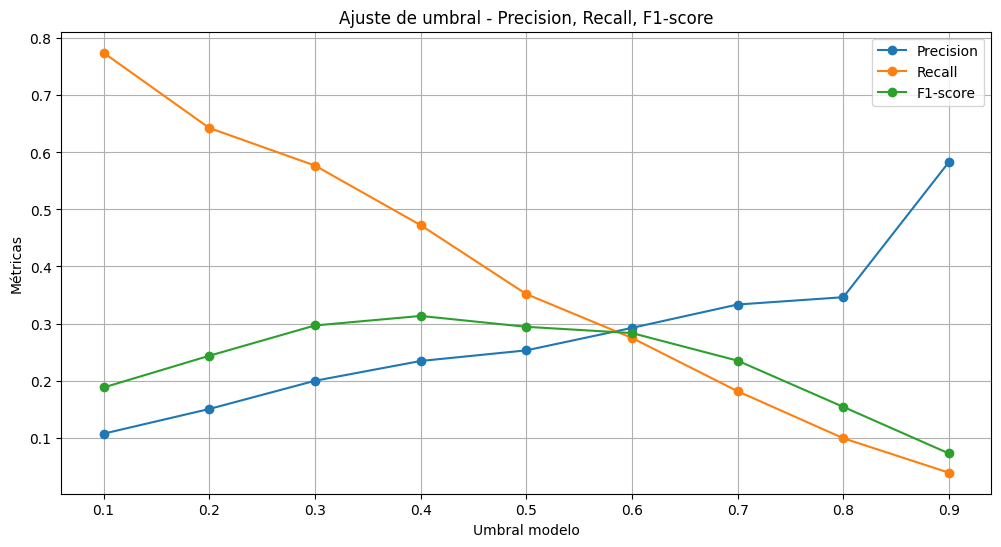

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.xlabel('Umbral modelo')
plt.ylabel('Métricas')
plt.title('Ajuste de umbral - Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.show()


In [123]:
# Coste de un falso positivo (enviar un HELICOPTERO DE TRANSPORTE innecesariamente)
cost_fp = 1096.88  # Coste de enviar un HELICOPTERO DE TRANSPORTE segun los datos que tenemos en la introducción de coste hora.
# pongo un *2 porque en la comunidad valenciana tienen 1

# Estimación del coste de un falso negativo (no enviar un HELICOPTERO DE TRANSPORTE cuando es necesario)
cost_fn = (6343*0.07) # Un valor extraido de las hectarias mediana (medias muy altas) quemadas en los datos obtenidos 
#y el coste medio de perdida medio ambiental segúnhttps://evenor-tech.com/el-coste-economico-de-los-incendios-forestales/

thresholds = np.arange(0.1, 1.0, 0.1)
total_costs = []

for threshold in thresholds:
    # Aplicar el umbral para hacer las predicciones ajustadas
    y_pred_adjusted = (preds >= threshold).astype(int)
    
    # Calculoo FP y FN
    false_positive = ((y_pred_adjusted == 1) & (y_test == 0)).sum()
    false_negative = ((y_pred_adjusted == 0) & (y_test == 1)).sum()

    # Coste total
    total_cost = (false_positive * cost_fp) + (false_negative * cost_fn)
    total_costs.append(total_cost)


for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Coste total: {total_costs[i]:.2f} €")

Umbral: 0.1, Coste total: 1310329.05 €
Umbral: 0.2, Coste total: 754995.21 €
Umbral: 0.3, Coste total: 495975.25 €
Umbral: 0.4, Coste total: 350848.24 €
Umbral: 0.5, Coste total: 259703.50 €
Umbral: 0.6, Coste total: 191331.80 €
Umbral: 0.7, Coste total: 138551.57 €
Umbral: 0.8, Coste total: 110111.56 €
Umbral: 0.9, Coste total: 83186.15 €


In [125]:
# Ajuste umbral
threshold = 0.4
y_pred_adjusted = (preds  >= threshold).astype(int)

In [126]:
print(confusion_matrix(y_test, y_pred_adjusted))

print(classification_report(y_test, y_pred_adjusted))

[[2695  281]
 [  96   86]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.93      2976
           1       0.23      0.47      0.31       182

    accuracy                           0.88      3158
   macro avg       0.60      0.69      0.62      3158
weighted avg       0.92      0.88      0.90      3158



In [1283]:
filename = '../Modelos/Aviones_descarga/best_lgb_anfibio.pkl'

In [1284]:
model_and_threshold = {
    'model': best_light_gbm,
    'threshold': threshold}

    
joblib.dump(model_and_threshold, filename)

['../Modelos/Aviones_descarga/best_lgb_anfibio.pkl']

### 4.3 Cat Boosting

In [224]:

X = data_filtrado[['COMARCA','DifficultyIndex','D_APIE','D_VIENTO','DULLUVIA',
             'EROSION','ESTACION','Elevation','FuelLoadIndex','Humidity (%)','IND_PEL','LandCover',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_fuel','difficulty_viento_humedad']]
y = data_filtrado[ 'AVIANFNUM_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
catboost_model = CatBoostClassifier(iterations=1000, 
                                    learning_rate=0.1, 
                                    depth=6, 
                                    verbose=200,
                                    random_state=42)

In [78]:
catboost_model.fit(X_train, y_train)

0:	learn: 0.5722474	total: 2.65ms	remaining: 2.65s
200:	learn: 0.0929665	total: 324ms	remaining: 1.29s
400:	learn: 0.0569284	total: 620ms	remaining: 926ms
600:	learn: 0.0361116	total: 912ms	remaining: 605ms
800:	learn: 0.0241717	total: 1.2s	remaining: 298ms
999:	learn: 0.0175510	total: 1.49s	remaining: 0us


In [80]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(catboost_model.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(catboost_model.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.9395
Precisión sobre el juego de train: 0.9992


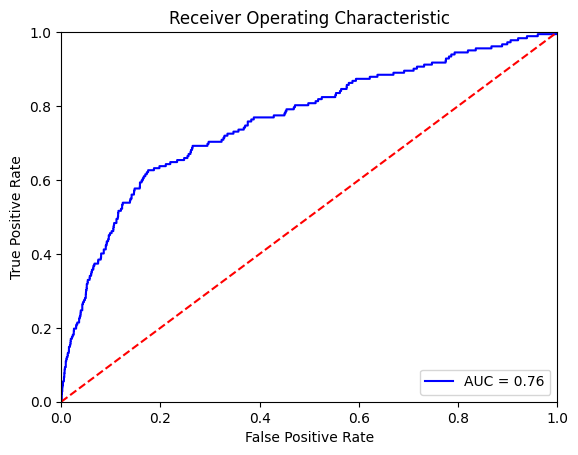

In [82]:
probs = catboost_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [84]:
predicciones = catboost_model.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2949   27]
 [ 164   18]]

El accuracy de test es: 93.95186827105763 %
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2976
           1       0.40      0.10      0.16       182

    accuracy                           0.94      3158
   macro avg       0.67      0.54      0.56      3158
weighted avg       0.92      0.94      0.92      3158



In [87]:

param_grid = {
    'iterations': [100, 200, 300, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'l2_leaf_reg': [1, 3, 5, 10],  
    'border_count': [32, 64, 128]
}

In [88]:
cat_random = RandomizedSearchCV(estimator = catboost_model, 
                                   param_distributions = param_grid, 
                                   n_iter = 50, 
                                   cv = 5, 
                                   scoring='roc_auc',
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = 1)

In [89]:
cat_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0:	learn: 0.6792629	total: 4.75ms	remaining: 1.42s
200:	learn: 0.1588879	total: 340ms	remaining: 168ms
299:	learn: 0.1377571	total: 507ms	remaining: 0us
0:	learn: 0.6792924	total: 1.95ms	remaining: 584ms
200:	learn: 0.1607859	total: 334ms	remaining: 164ms
299:	learn: 0.1404317	total: 506ms	remaining: 0us
0:	learn: 0.6791388	total: 1.86ms	remaining: 556ms
200:	learn: 0.1588151	total: 332ms	remaining: 163ms
299:	learn: 0.1376607	total: 523ms	remaining: 0us
0:	learn: 0.6791826	total: 1.76ms	remaining: 528ms
200:	learn: 0.1579318	total: 340ms	remaining: 168ms
299:	learn: 0.1364039	total: 504ms	remaining: 0us
0:	learn: 0.6791081	total: 2.5ms	remaining: 748ms
200:	learn: 0.1582810	total: 331ms	remaining: 163ms
299:	learn: 0.1370162	total: 495ms	remaining: 0us
0:	learn: 0.6299814	total: 1.06ms	remaining: 1.06s
200:	learn: 0.1271898	total: 224ms	remaining: 892ms
400:	learn: 0.0978358	total: 448ms	remaining: 670ms
600:	learn: 0.07891

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x17fe93e30>,
                   n_iter=50, n_jobs=1,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 300, 500,
                                                       1000],
                                        'l2_leaf_reg': [1, 3, 5, 10],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [94]:
best_cat = cat_random.best_estimator_

<BarContainer object of 18 artists>

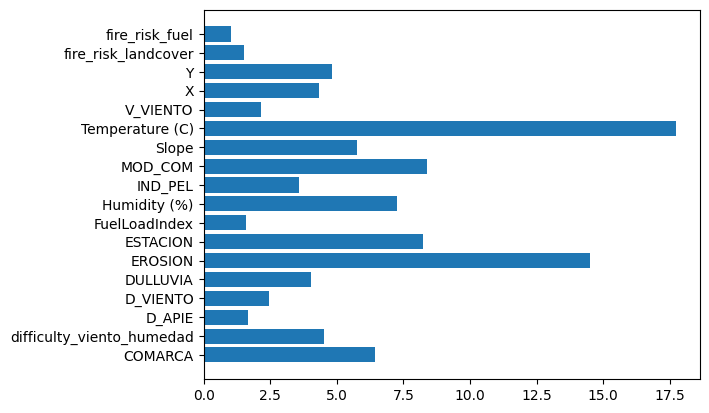

In [95]:
plt.barh(X.columns, best_cat.feature_importances_)

In [96]:
best_cat.fit(X_train,y_train)

0:	learn: 0.6202705	total: 1.06ms	remaining: 105ms
99:	learn: 0.1527982	total: 77.2ms	remaining: 0us


In [98]:
print('BALANCED_ BEST_PARAMS_')

print("Precisión sobre el juego de test: {:.4f}"
      .format(best_cat.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_cat.score(X_train, y_train)))

BALANCED_ BEST_PARAMS_
Precisión sobre el juego de test: 0.9421
Precisión sobre el juego de train: 0.9490


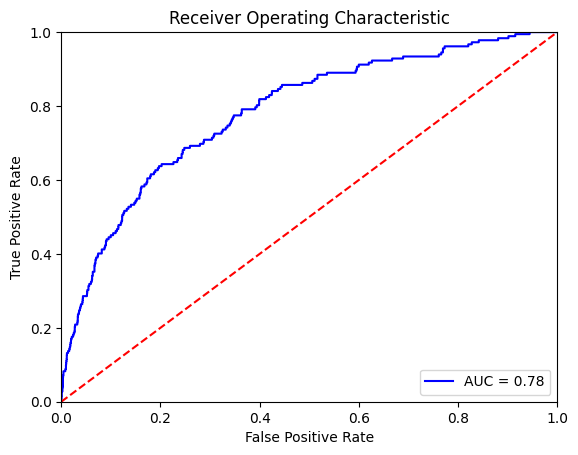

In [100]:
probs = best_cat.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [102]:
predicciones = best_cat.predict(X_test)
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2968    8]
 [ 175    7]]

El accuracy de test es: 94.20519316022799 %
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2976
           1       0.47      0.04      0.07       182

    accuracy                           0.94      3158
   macro avg       0.71      0.52      0.52      3158
weighted avg       0.92      0.94      0.92      3158



In [104]:
#Rango umbrales en pasos pequeños
thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

# Metricas por umbral
for threshold in thresholds:
    y_pred_adjusted = (preds >= threshold).astype(int)  # Aplicar el umbral
    precisions.append(precision_score(y_test, y_pred_adjusted))
    recalls.append(recall_score(y_test, y_pred_adjusted))
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# resultados
for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}, F1-score: {f1_scores[i]:.4f}")


Umbral: 0.1, Precision: 0.2009, Recall: 0.4780, F1-score: 0.2829
Umbral: 0.2, Precision: 0.2941, Recall: 0.2473, F1-score: 0.2687
Umbral: 0.3, Precision: 0.3472, Recall: 0.1374, F1-score: 0.1969
Umbral: 0.4, Precision: 0.5000, Recall: 0.0824, F1-score: 0.1415
Umbral: 0.5, Precision: 0.4667, Recall: 0.0385, F1-score: 0.0711
Umbral: 0.6, Precision: 0.5000, Recall: 0.0165, F1-score: 0.0319
Umbral: 0.7, Precision: 0.6667, Recall: 0.0110, F1-score: 0.0216
Umbral: 0.8, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Umbral: 0.9, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


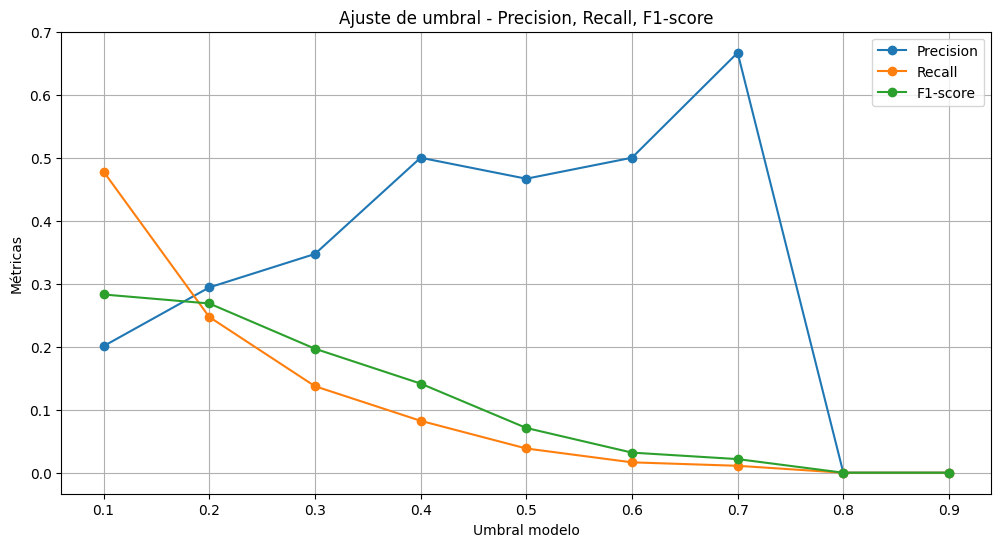

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.xlabel('Umbral modelo')
plt.ylabel('Métricas')
plt.title('Ajuste de umbral - Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.show()


In [106]:
# Coste de un falso positivo (enviar un avión innecesariamente)
cost_fp = 4208.61*2  # Coste de enviar un avión segun los datos que tenemos en la introducción de coste hora.
# pongo un *2 porque en la comunidad valenciana tienen 2 y suponemos que mandamos todas las unidades

# Estimación del coste de un falso negativo (no enviar un avión cuando es necesario)
cost_fn = (6343*0.07) # Un valor extraido de las hectarias mediana (medias muy altas) quemadas en los datos obtenidos 
#y el coste medio de perdida medio ambiental segúnhttps://evenor-tech.com/el-coste-economico-de-los-incendios-forestales/

thresholds = np.arange(0.1, 1.0, 0.1)
total_costs = []

for threshold in thresholds:
    # Utilizo umbral del for
    y_pred_adjusted = (preds >= threshold).astype(int)
    
    # Calculoo FP y FN
    false_positive = ((y_pred_adjusted == 1) & (y_test == 0)).sum()
    false_negative = ((y_pred_adjusted == 0) & (y_test == 1)).sum()

    # Coste total
    total_cost = (false_positive * cost_fp) + (false_negative * cost_fn)
    total_costs.append(total_cost)


for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.2f}, Coste total: {total_costs[i]:.2f} €")

Umbral: 0.10, Coste total: 2954539.07 €
Umbral: 0.20, Coste total: 969889.13 €
Umbral: 0.30, Coste total: 465318.91 €
Umbral: 0.40, Coste total: 200407.97 €
Umbral: 0.50, Coste total: 145039.51 €
Umbral: 0.60, Coste total: 104729.45 €
Umbral: 0.70, Coste total: 88339.02 €
Umbral: 0.80, Coste total: 80809.82 €
Umbral: 0.90, Coste total: 80809.82 €


In [107]:
# Ajuste umbral
threshold = 0.15
y_pred_adjusted = (preds  >= threshold).astype(int)

In [108]:
print(confusion_matrix(y_test, y_pred_adjusted))

print(classification_report(y_test, y_pred_adjusted))



[[2793  183]
 [ 123   59]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2976
           1       0.24      0.32      0.28       182

    accuracy                           0.90      3158
   macro avg       0.60      0.63      0.61      3158
weighted avg       0.92      0.90      0.91      3158



In [139]:
filename = '../Modelos/Aviones_descarga/best_cat_anfibio.pkl'

In [140]:
model_and_threshold = {
    'model': best_cat,
    'threshold': threshold}

    
joblib.dump(model_and_threshold, filename)

['../Modelos/Aviones_descarga/best_cat_anfibio.pkl']

### Ejemplo uso practico



In [ ]:

def avionANFI(data):
    """
    Función para predecir si se debe enviar un avión basado en las características dadas.

    Args:
        data (dict): dar un diccionario con las variables que hemos definido en el modelo
   
    """
    # Asegurar orden igual que en el modelo porque si no en la lectura del .pkl dara error
    features = ['Slope', 'TEMPMAX', 'V_VIENTO', 'H_RELAT', 'DifficultyIndex',
                'Elevation', 'TOT_EST', 'ENP_1', 'EIMP_GLOB', 'SHAPE_AREA',
                'BOMBEROS', 'GUARCIVIL'] 

    try:
        # ordeanar
        input_data = np.array([data[feature] for feature in features]).reshape(1, -1)

        # Probabilidad segun el modelo que hemos creado y cargado luego como 'best_model'
        probability = best_model.predict_proba(input_data)[0, 1]  

        # Metemos recomendación un umbral de probabilidad del 80%. Se pone esta probailidad para se etractos ya que puede que en la creación del modelo hayamos medito algun falso positivo
        recommendation = "Si, enviar" if probability >= 0.8 else "No, no enviar"

        return {
            "probability": probability,
            "recommendation": recommendation
        }

    except KeyError as e:
        return {"error": f"Falta la característica requerida: {e}"}
    except Exception as e:
        return {"error": f"Ocurrió un error: {e}"}


In [13]:
# Carga el modelo con joblib
best_model = load('./Modelos/Aviones_descarga/best_light_gbm(2).pkl')

data = {
    'Slope': 11,
    'TEMPMAX': 18,
    'V_VIENTO': 5,
    'H_RELAT': 82,
    'DifficultyIndex': 0,
    'Elevation': 500.0,
    'TOT_EST': 10,
    'ENP_1': 0,
    'EIMP_GLOB': 3,
    'SHAPE_AREA': 214534.97,
    'BOMBEROS': 4,
    'GUARCIVIL': 14
    

}

In [14]:
result = aviondescarga(data)
print(result)


{'probability': 0.6927540949712792, 'recommendation': 'No, no enviar'}


## Modelos Regresión

una vez que sabemos si necesitamos o no Helicopteros de descarga lo siguiente que tenemos que saber en cada situcion cuantos necesitaríamos


In [143]:

X = data_filtrado[['COMARCA','DifficultyIndex','D_APIE','D_VIENTO','DULLUVIA',
             'EROSION','ESTACION','Elevation','FuelLoadIndex','Humidity (%)','IND_PEL','LandCover',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_fuel','difficulty_viento_humedad']]
y = data_filtrado[ 'AVIANFNUM']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

Va a ser el primer modelo que usamos para poder hacer un aprendizaje supervisado para ello pasaremos de una primera configuracion donde no vamos a ajustar el modelo si no que lo dejamos de fabrica y luego vamos a intentar ajustar los hiperparametros para poder mejorar las metricas de este y que el test y train mejore a la par y no que haya un sobre ajuste que suele producirse 

Pruebo a hacer el random Forest con los datos predeterminados 

In [144]:
# Modelo de Random Forest Regressor
forest = RandomForestRegressor(random_state=123)


In [145]:
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

Como no hemos aplicado el cross validation se produce un sobreajuste de los datos por lo tanto a partir de ahora es cuando se juega con lo parametros para conseguir mejores valores

In [147]:

# Evaluar el modelo inicial
y_pred = forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE del modelo inicial: {mse}")
print(f"MAE del modelo inicial: {mae}")
print(f"R2 del modelo inicial: {r2}")



MSE del modelo inicial: 0.3864634039324261
MAE del modelo inicial: 0.20355821236376792
R2 del modelo inicial: 0.41545507684649496


In [148]:
# Hiperparametros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [ None, 10, 2, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [5, 7, 9]
}



In [149]:
combinaciones = ParameterGrid(param_grid)

In [150]:
# Diccionario para almacenar los resultados
resultados = {'params': [], 'mse': [], 'mae': [], 'r2': []}

# Entreno del modelo por parametros

for params in combinaciones:
    modelo = RandomForestRegressor(
        random_state=123,
        **params
    )

    # Entrenar el modelo
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Guardar los resultados
    resultados['params'].append(params)
    resultados['mse'].append(mse)
    resultados['mae'].append(mae)
    resultados['r2'].append(r2)

In [151]:

resultados_df = pd.DataFrame(resultados)
resultados_df = pd.concat([resultados_df, resultados_df['params'].apply(pd.Series)], axis=1)
resultados_df = resultados_df.drop(columns='params')
resultados_df = resultados_df.sort_values('mse', ascending=True)  # Ordenar por menor MSE

resultados_df.head()


mse       mae        r2  max_depth  max_features  min_samples_leaf  \
109  0.367175  0.194410  0.444630       10.0           7.0               1.0   
110  0.367960  0.194801  0.443442       10.0           7.0               1.0   
135  0.369953  0.193868  0.440428       10.0           9.0               1.0   
2    0.370973  0.202390  0.438885        NaN           5.0               1.0   
245  0.371338  0.202359  0.438333       30.0           5.0               1.0   

     min_samples_split  n_estimators  
109                2.0         100.0  
110                2.0         200.0  
135                2.0          50.0  
2                  2.0         200.0  
245                2.0         200.0

In [152]:

# mejor modelo
mejores_params = resultados_df.iloc[0].drop(['mse', 'mae', 'r2']).to_dict()
for key, value in mejores_params.items():
    if isinstance(value, float) and value.is_integer():
        mejores_params[key] = int(value)
        
modelo_final = RandomForestRegressor(random_state=123, **mejores_params)
modelo_final.fit(X_train, y_train)



RandomForestRegressor(max_depth=10, max_features=7, random_state=123)

In [153]:
# modelo final
y_pred_final = modelo_final.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)


print(f"MSE del modelo final: {mse_final}")
print(f"MAE del modelo final: {mae_final}")
print(f"R2 del modelo final: {r2_final}")

MSE del modelo final: 0.3671750718367893
MAE del modelo final: 0.19441011356047014
R2 del modelo final: 0.4446296286614314


Ahora voy a intentar mejorar el modelo con los hiperparametros antes de empezar a a usar nueva variables

Importancia de las características en el modelo Random Forest:
                           Importancia
COMARCA                       0.033576
DifficultyIndex               0.040378
D_APIE                        0.046836
D_VIENTO                      0.026138
DULLUVIA                      0.040519
EROSION                       0.052142
ESTACION                      0.040034
Elevation                     0.068953
FuelLoadIndex                 0.014117
Humidity (%)                  0.129016
IND_PEL                       0.021900
LandCover                     0.012183
MOD_COM                       0.081344
Slope                         0.052507
Temperature (C)               0.086344
V_VIENTO                      0.031750
X                             0.053096
Y                             0.064202
fire_risk_fuel                0.063455
difficulty_viento_humedad     0.041509


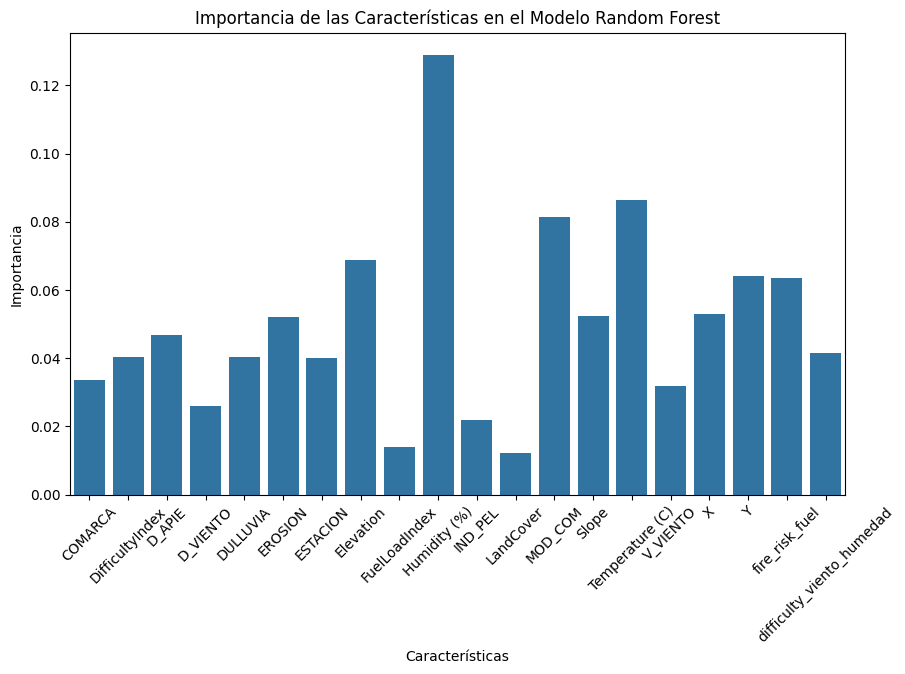

In [154]:

# Importancia de las características en el modelo Random Forest
feature_importances = forest.feature_importances_
feature_importance_df = pd.DataFrame(feature_importances, index=X.columns, columns=['Importancia'])
print('Importancia de las características en el modelo Random Forest:')
print(feature_importance_df)

# Graficar la importancia de las características en el modelo Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df.index, y=feature_importance_df['Importancia'])
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation = 45)
plt.show()


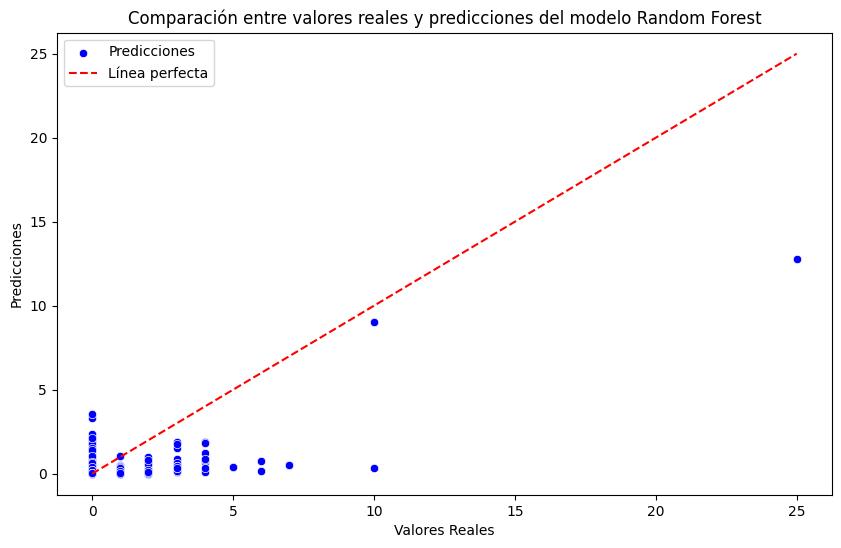

In [155]:
# Crear un DataFrame con las predicciones y los valores reales
predictions_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred_final})

# Graficar la comparación entre los valores reales y las predicciones
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Real', y='Predicción', data=predictions_df, color='blue', label='Predicciones')
plt.plot([predictions_df['Real'].min(), predictions_df['Real'].max()],
         [predictions_df['Real'].min(), predictions_df['Real'].max()],
         color='red', linestyle='--', label='Línea perfecta')

# Etiquetas y título
plt.title('Comparación entre valores reales y predicciones del modelo Random Forest')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()

# Mostrar gráfico
plt.show()


In [164]:
filename = '../Modelos/Aviones_descarga/regresion_anfibio.pkl'
joblib.dump(modelo_final, filename)
    

['../Modelos/Aviones_descarga/regresion_anfibio.pkl']